In [1]:
""" O livro pede para importar o data set de Boston, como na versão que estou utilizando o dataset não está disponível, estou associando ao de Diabetes

Vou tentar replicar o exemplo fazendo um paralelo com outro dataset.
"""

from sklearn.datasets import load_diabetes

import random
from random import shuffle

diabetes = load_diabetes()
random.seed(0) #Creates a replicable suffling

new_index = list(range(diabetes.data.shape[0]))
shuffle(new_index) ## shuffling the index
X, y = diabetes.data[new_index], diabetes.target[new_index]
print(X.shape, y.shape, diabetes.feature_names)

(442, 10) (442,) ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection  import cross_val_score, KFold
regression = LinearRegression(fit_intercept=True)
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

In [15]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [2]:
import pandas as pd
df = pd.DataFrame(X, columns=diabetes.feature_names)
df['target'] = y

C:\Users\thiag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\plotting\_matplotlib\core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


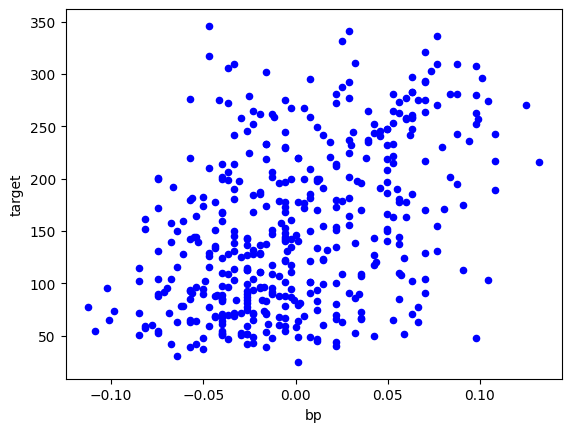

In [19]:
ax = df.plot(kind='scatter', x='bp', y='target', c='b')

In [24]:
# Adding polynomial features (x**2,y**2,xy)
polyX = pd.DataFrame(X,columns=diabetes.feature_names)
cv = cross_val_score(regression, polyX, y, 
                     scoring='neg_mean_squared_error', 
                     cv=crossvalidation)
baseline = np.mean(cv)
improvements = [baseline]
for var_A in diabetes.feature_names: 
    polyX[var_A+'^2'] = polyX[var_A]**2
    cv = cross_val_score(regression, polyX, y, 
                         scoring='neg_mean_squared_error', 
                         cv=crossvalidation)
    improvements.append(np.mean(cv))
    for var_B in diabetes.feature_names:
        if var_A > var_B:
            poly_var = var_A + '*' + var_B
            polyX[poly_var] = polyX[var_A] * polyX[var_B]
            cv = cross_val_score(regression, polyX, y, 
                         scoring='neg_mean_squared_error', 
                         cv=crossvalidation)
            improvements.append(np.mean(cv))

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import numpy as np

ridge = Ridge(alpha=1)
search_grid = {'alpha':np.logspace(-5,2,8)}
search = GridSearchCV(estimator=ridge,
                      param_grid=search_grid,
                      scoring='neg_mean_squared_error',
                      refit=True, cv=10)

search.fit(polyX,y)
print('Best parameters: %s' % search.best_params_)
score = abs(search.best_score_)
print('CV MSE of best parameters: %.3f' % score)


Best parameters: {'alpha': 0.01}
CV MSE of best parameters: 2945.298


In [26]:
from sklearn.linear_model import Lasso
lasso = Lasso(fit_intercept=True, tol=0.05, selection='random')
search_grid = {'alpha':np.logspace(-2,3,8)}
search = GridSearchCV(estimator=lasso,
                      param_grid=search_grid,
                      scoring='neg_mean_squared_error',
                      refit=True, cv=10)

search.fit(polyX,y)
print('Best parameters: %s' % search.best_params_)
score= abs(search.best_score_)
print('CV MSE of best parameters: %.3f' % score) # Erro quadráico médio

Best parameters: {'alpha': 0.01}
CV MSE of best parameters: 2933.643


In [29]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

SGD = SGDRegressor(loss="squared_error",
                   penalty='l2',
                   alpha=0.0001,
                   l1_ratio=0.15,
                   max_iter=2000,
                   random_state=1)

scaling = StandardScaler()
scaling.fit(polyX)
scaled_X = scaling.transform(polyX)
cv = cross_val_score(SGD, scaled_X, y, 
                     scoring='neg_mean_squared_error',
                     cv=crossvalidation)

score = abs(np.mean(cv))
print('CV MSE: %.3f' % score)

CV MSE: 3344.198


In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_tr, X_t, y_tr, y_t = train_test_split(scaled_X, y, 
                                        test_size=0.20,
                                        random_state=2)

SGD = SGDRegressor(loss='squared_error',
                   penalty='l2',
                   alpha=0.0001,
                   l1_ratio=0.15,
                   max_iter=2000,
                   random_state=1)

improvements = list()
for z in range(10000):
    SGD.partial_fit(X_tr, y_tr)
    score = mean_squared_error(y_t, SGD.predict(X_t))
    improvements.append(score)

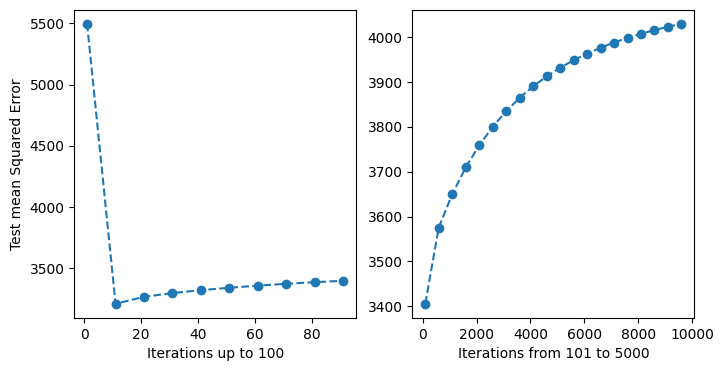

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
range_1 = range(1,101,10)
score_1 = np.abs(improvements[:100:10])
plt.plot(range_1, score_1, 'o--')
plt.xlabel('Iterations up to 100')
plt.ylabel('Test mean Squared Error')
plt.subplot(1,2,2)

range_2 = range(100,10000,500)
score_2 = np.abs(improvements[100:10000:500])
plt.plot(range_2, score_2, 'o--')
plt.xlabel('Iterations from 101 to 5000')
plt.show()

""" De acordo com o livro, o primeiro gráfico mostra a Taxa de erros, nota-se que ela começa alta e após algumas interações ela melhora lentamente, e fica em uma constante.

O Segundo painel deveria mostrar que depois de algumas interações (se vc olhar o Notebook do autor na pasta PYthonDataScience nesse repositorio) a taxa de erro alcança um mínimo
e vai aumentando porque só aprende com os ruídos e regras errôneas, no meu caso, ele começa bem mas a parabola mostra que o meu modelo não aprendeu nada com os dados que coloquei,
ou seja, ele piora conforme o número de interações. 


"""